# $\Phi$-SO demo : Manipulating expressions

This notebook demonstrates how `physo` expressions can be manipulated and showcases important available features.

This includes:
- __Flexible export__: Expressions can be exported to various formats including (differentiable) python functions, SymPy objects, LaTeX, strings and saved on disk.
- __Evaluation and parameter fitting__: Expressions can be numerically evaluated, and their free parameters optimized as needed (in parallel across a batch of equations if desired).
- __Encoding__: Expressions' numerical encoding can be accessed easily, facilitating the use of expressions for machine learning purposes.
- __Auto-differentiable structures__: Expression trees are compatible with automatic differentiation.
- __Tree structure navigation__: The expression tree can be displayed and navigated. This can be used to access e.g. parent, children, and sibling nodes of any token, and even list their ancestors in a vectorized way across all expressions in the batch.
- __Physical Units information__: Physical units of each token is dynamically computed and stored in the expression tree.
- __One equation, multiple datasets__: Expressions can contain dataset-specific free constant values through, allowing for a single equation to be evaluated and fitted across multiple datasets.

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings

In [14]:
# Internal code import
import physo
import physo.physym.dataset as phyd
import physo.toolkit.random_sampler as rs

Seed

In [15]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

Device

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Accessing expressions properties

Let's generate a batch of random expressions for demonstration purposes.

In [18]:
expressions = rs.sample_random_expressions(
    # Batch size
    batch_size=1000,
    # Max length
    max_length=30,
    # Soft length prior
    length_soft_loc= 12.,
    length_soft_scale= 5.,
    # X
    X_names = ["x1", "x2", "x3", "x4", "x5", "x6",],
    # y
    y_name = "y",
    # Fixed constants
    fixed_consts       = [1.],
    # Free constants
    free_consts_names = ["c0", "c1", "c2",],
    # Operations to use
    op_names = ["add", "sub", "mul", "div", "pow", "log", "exp", "cos"],
    # Device to use
    device=device,
    # verbose
    verbose=False
)

### Acessing free parameter values

In [19]:
# Free constants values are stored in :
print(expressions.free_consts)
# They can be sent to the device via:
expressions.free_consts.to(device)
# Values are stored in :
print(expressions.free_consts.class_values)
print(expressions.free_consts.class_values.shape)

FreeConstantsTable
 -> Class consts (['c0' 'c1' 'c2']) : (1000, np.int64(3))
 -> Spe consts   ([]) : (1000, np.int64(0), 1)
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
torch.Size([1000, 3])


Let's give random values to the free constants.

In [20]:
expressions.free_consts.class_values = torch.rand_like(expressions.free_consts.class_values, device=device)
print(expressions.free_consts.class_values)
print(expressions.free_consts.class_values.shape)

tensor([[0.0582, 0.0629, 0.1236],
        [0.0526, 0.5262, 0.4768],
        [0.9552, 0.9288, 0.0835],
        ...,
        [0.4071, 0.9441, 0.1419],
        [0.7524, 0.1257, 0.0955],
        [0.4455, 0.0133, 0.6559]], dtype=torch.float64)
torch.Size([1000, 3])


### Inspecting \& displaying an expression

Let's inspect expression number 21 of the batch.

In [21]:
expr = expressions[21]

Showing expression in all available formats:

In [22]:
print("Infix str:\n", (expr.get_infix_str()))

Infix str:
 (log(cos((x2*c2)))*cos(x6))


Prefix notation:
 [mul log cos mul x2 c2 cos x6]
Sympy:
 log(cos(c2*x2))*cos(x6)
Infix representation str:
 (log(cos((x2*c2)))*cos(x6))
Pretty
:
log(cos(c₂⋅x₂))⋅cos(x₆)
Latex:
 \log{\left(\cos{\left(c_{2} x_{2} \right)} \right)} \cos{\left(x_{6} \right)}


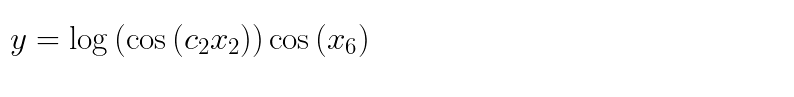

Image:
 None


In [23]:
print("Prefix notation:\n", expr)
print("Sympy:\n", (expr.get_infix_sympy()))
print("Infix representation str:\n", (expr.get_infix_str()))
print("Pretty\n:")
print(expr.get_infix_pretty())
print("Latex:\n", expr.get_infix_latex())
print("Image:\n", expr.show_infix())

Expressions can also be showed with evaluated constants:

In [24]:
print(expr.get_infix_sympy(evaluate_consts=True)[0])

log(cos(0.441587102889625*x2))*cos(x6)


### Saving/Loading an expression

In [ ]:
fpath = "my_expression.pkl"
# Saving an expression to a file
expr.save(fpath)
# Loading an expression from a file
expr = physo.load_program_pkl(fpath)
# Deleting the file
os.remove(fpath) if os.path.exists(fpath) else None

### Evaluating an expression


Free consts: tensor([[0.6308, 0.3539, 0.4416]], dtype=torch.float64)


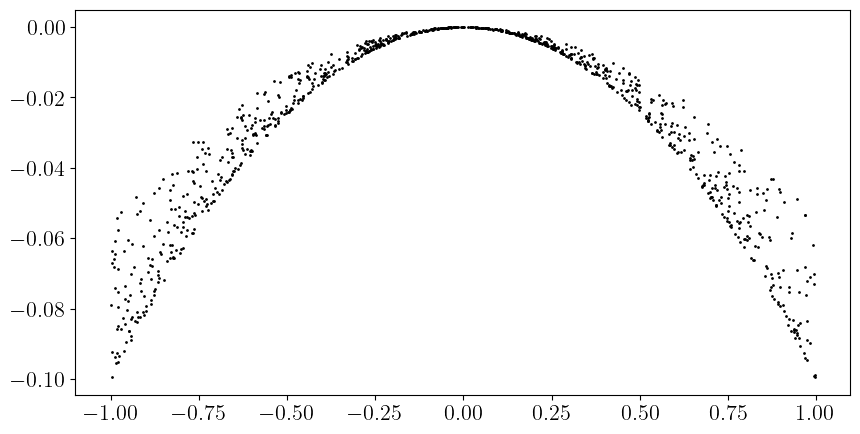

In [25]:
# Making synthetic data
n_samples = 1000
X = torch.tensor(np.random.uniform(-1, 1, size=(6, n_samples))).to(device)
# Evaluating the expression
y = expr(X)
# Showing free constants values
print("Free consts:", expr.free_consts.class_values)
# Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(X[1].cpu().numpy(), y.detach().cpu().numpy(), 'k.', markersize=2, label='Data')


### Optimizing free parameters of an expression

Note that free constant optimization is typically faster on the CPU.

Making fake target data to optimize the expression.

In [26]:
# Target data with current free constants values
y_target = expr(X)
# Randomizing free constants values
expr.free_consts.class_values = torch.rand((1,3), device=device)
const_before_opti = expr.free_consts.class_values
print("Free consts (before optimization):", const_before_opti)

Free consts (before optimization): tensor([[0.2120, 0.3880, 0.9504]])


Optimizing the expression

Free consts (after optimization): tensor([[0.2120, 0.3880, 0.4416]], requires_grad=True)


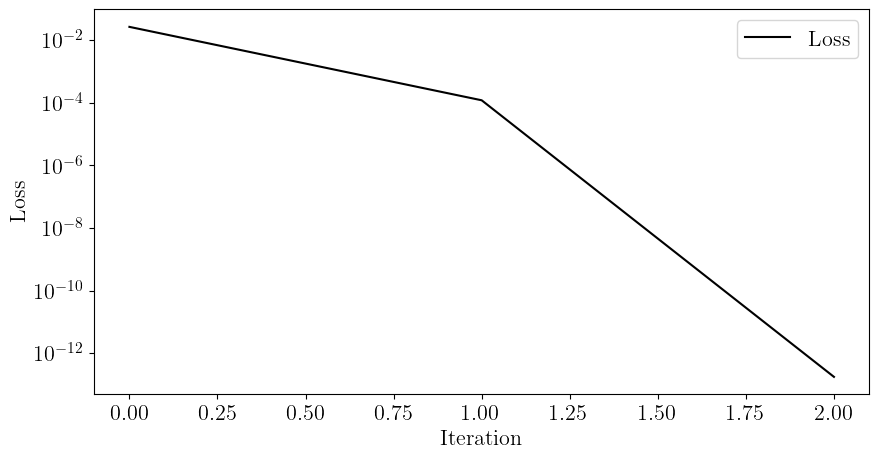

In [27]:
history = expr.optimize_constants(X, y_target)

# Showing free constants values
const_after_opti = expr.free_consts.class_values
print("Free consts (after optimization):", const_after_opti)

# Showing optimization history
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history, label='Loss', color='k')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()
plt.show()

Text(0, 0.5, 'Predicted y')

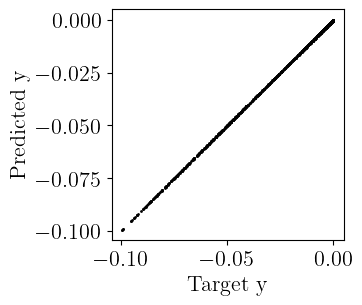

In [28]:
# Fitness
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(y_target.detach().cpu().numpy(), expr(X).detach().cpu().numpy(), 'k.', markersize=2,)
ax.set_xlabel('Target y')
ax.set_ylabel('Predicted y')

Parallel optimization of all expressions in a batch

In [29]:
expressions = rs.sample_random_expressions(
    # Batch size
    batch_size=50,
    # Max length
    max_length=30,
    # Soft length prior
    length_soft_loc= 12.,
    length_soft_scale= 5.,
    # X
    X_names = ["x1", "x2", "x3", "x4", "x5", "x6",],
    # y
    y_name = "y",
    # Fixed constants
    fixed_consts       = [1.],
    # Free constants
    free_consts_names = ["c0", "c1", "c2",],
    # Operations to use
    op_names = ["add", "sub", "mul", "div", "pow", "log", "exp", "cos"],
    # Device to use
    device=device,
    # verbose
    verbose=False
)

In [30]:
expressions.batch_optimize_constants(X, y_target,
                                     # Parallel related
                                     parallel_mode         = False, # Parallel mode is not available on jupyter notebooks.
                                     n_cpus                = None,)

### Accessing encoding

The library of available tokens depends on the config used to generate the expressions, it can be accessed via the `library` attribute of the expressions object.

In [31]:
lib = expressions.library
print(lib)

[add sub mul div pow log exp cos 1.0 c0 c1 c2 x1 x2 x3 x4 x5 x6 y dummy -]


In [32]:
# Encoding : dict of token names to indices
lib.lib_name_to_idx

{np.str_('add'): 0,
 np.str_('sub'): 1,
 np.str_('mul'): 2,
 np.str_('div'): 3,
 np.str_('pow'): 4,
 np.str_('log'): 5,
 np.str_('exp'): 6,
 np.str_('cos'): 7,
 np.str_('1.0'): 8,
 np.str_('c0'): 9,
 np.str_('c1'): 10,
 np.str_('c2'): 11,
 np.str_('x1'): 12,
 np.str_('x2'): 13,
 np.str_('x3'): 14,
 np.str_('x4'): 15,
 np.str_('x5'): 16,
 np.str_('x6'): 17,
 np.str_('y'): 18,
 np.str_('dummy'): 19,
 np.str_('-'): 20}

In [33]:
print("Number of choosable tokens in the library:", lib.n_choices)
print("Token idx used for padding after expression:", lib.invalid_idx)

Number of choosable tokens in the library: 18
Token idx used for padding after expression: 20


Tokens are stored in the `tokens` attribute of the expressions object.
Let's access all tokens of all expressions in the batch.

In [34]:
print("Encoded tokens:")
print(expressions.tokens.idx)                    # (batch_size, max_length)
print("Tokens as str:")
expressions.idx_as_names(expressions.tokens.idx) # (batch_size, max_length)

Encoded tokens:
[[ 0  7  6 ... 20 20 20]
 [ 0  6  1 ... 20 20 20]
 [ 6  7  3 ... 20 20 20]
 ...
 [ 5  4  9 ... 20 20 20]
 [ 3  1 11 ... 20 20 20]
 [ 5  0  8 ... 20 20 20]]
Tokens as str:


array([['add', 'cos', 'exp', ..., '-', '-', '-'],
       ['add', 'exp', 'sub', ..., '-', '-', '-'],
       ['exp', 'cos', 'div', ..., '-', '-', '-'],
       ...,
       ['log', 'pow', 'c0', ..., '-', '-', '-'],
       ['div', 'sub', 'c2', ..., '-', '-', '-'],
       ['log', 'add', '1.0', ..., '-', '-', '-']],
      shape=(50, 30), dtype='<U5')

In [35]:
print("Ie. %s encodes :"%(expressions.tokens.idx[21]))
print(expressions.get_infix_pretty(21))

Ie. [ 2  4 11 14  6  2 12  3  5 10 13 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20] encodes :
      x₁⋅log(c₁)
      ──────────
  x₃      x₂    
c₂  ⋅ℯ          


### Expressions are differentiable

In [36]:
print(expr.get_infix_pretty())

log(cos(c₂⋅x₂))⋅cos(x₆)


`physo` expressions are composed of PyTorch operators and are thus auto-differentiable, meaning that you can compute gradients with respect to the input variables or free constants.

In [37]:
# Making synthetic data
n_samples = 1000
X = torch.tensor(np.random.uniform(-1, 1, size=(6, n_samples))).to(device)
X.requires_grad = True
# Evaluating the expression
y = expr(X)
# Evaluating the expression with respect to the input variables
dy = torch.autograd.grad(
    outputs=y,
    inputs=X,
    grad_outputs=torch.ones_like(y),
    create_graph=True,
    retain_graph=True
)[0]
dy_dx2 = dy[1]  # Gradient with respect to x2

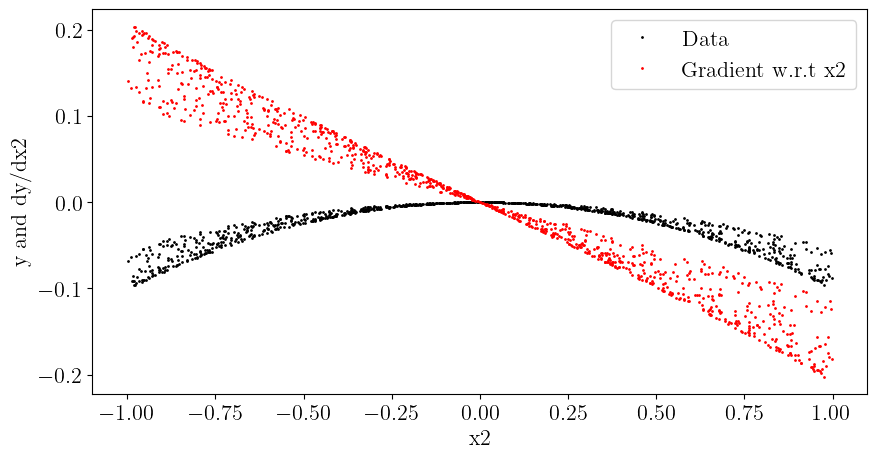

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(X[1].detach().cpu().numpy(), y.detach().cpu().numpy(), 'k.', markersize=2, label='Data')
ax.plot(X[1].detach().cpu().numpy(), dy_dx2.detach().cpu().numpy(), 'r.', markersize=2, label='Gradient w.r.t x2')
ax.set_xlabel('x2')
ax.set_ylabel('y and dy/dx2')
ax.legend()


### Accessing relational tree structure

`physo` expressions are stored as a tree structure, which can be navigated to access the parent, children, sibling nodes of any token and even list their ancestors in a vectorized way across all expressions in the batch.

In [39]:
print("Expression no 21:")
print(expressions.get_infix_pretty(21))
print("Expression no 42:")
print(expressions.get_infix_pretty(42))

Expression no 21:
      x₁⋅log(c₁)
      ──────────
  x₃      x₂    
c₂  ⋅ℯ          
Expression no 42:
                x₄⋅(1 - c₁)
54365636569181⋅ℯ           
───────────────────────────
      20000000000000       


In [40]:
print("Expression no 21:")
print(expressions[21])
print("Expression no 42:")
print(expressions[42])

Expression no 21:
[mul pow c2 x3 exp mul x1 div log c1 x2]
Expression no 42:
[exp sub 1.0 sub mul c1 x4 x4]


Getting parents of :
- Token no 1 of expression no 21
- Token no 5 of expression no 42

In [41]:
# Getting coordinates
coords =[[21,42],
         [1, 5]]
coords_parent = expressions.get_parent(coords)
# Getting parents tokens
parent = expressions.get_token(coords_parent)
child  = expressions.get_token(coords)


print("Parent of token no 1 of expression no 21: %s is %s" % (child[0], parent[0]))
print("Parent of token no 5 of expression no 42: %s is %s" % (child[1], parent[1]))

Parent of token no 1 of expression no 21: pow is mul
Parent of token no 5 of expression no 42: c1 is mul


In a similar manner, you can get the children of a token via `get_children`, the siblings via `get_siblings` and the ancestors via `get_ancestors`.

A tree representation can also be drawn via `show_tree`. However, it requires the installation of additional dependencies through [devreq.txt](https://github.com/WassimTenachi/PhySO/blob/main/devreq.txt).


Unable to import pdflatex (which is needed to make tree). Please install it via 'pip install pdflatex == 0.1.3'.


/var/folders/_0/hgcsx0091_b2v_kzxs1_yqyh0000gp/T/ipykernel_97391/2955651392.py:6: UserWarning: Tree visualization requires additional dependencies. Please install them via devreq.txt. Tree visualization is optional and not required for the use of physo.
  warnings.warn("Tree visualization requires additional dependencies. Please install them via devreq.txt. Tree visualization is optional and not required for the use of physo.")


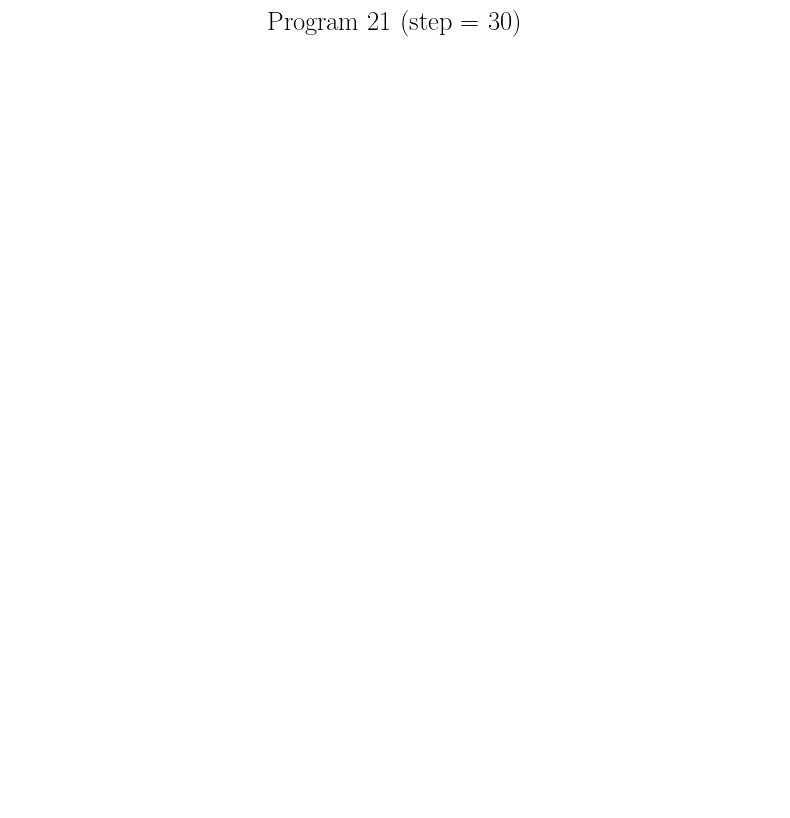

In [42]:
# Showing tree of expression no 21 and 42
try:
    expressions.show_tree(21, via_tex = True, figsize = (10,10), dpi = 300)
    expressions.show_tree(42, via_tex = True, figsize = (10,10), dpi = 300)
except:
    warnings.warn("Tree visualization requires additional dependencies. Please install them via devreq.txt. Tree visualization is optional and not required for the use of physo.")


### Accessing physical units information


Similarly, the physical units of a token can be accessed via the `tokens.phy_units` attribute of the expressions object.

In [43]:
# Are expressions physically correct?
for i in range (3):
    print("Is %s physical ? : %s"%(expressions_with_da.get_infix_str(i), expressions_with_da.is_physical[i]))

Is cos(((((t*log(((((((f-(l/(((L/f)-(L/f))-(l*t))))+f)/f)/1.0)-1.0)-1.0)))*f)+1.0)+1.0)) physical ? : True
Is (1.0+(f*(L/(((cos((exp(((L*1.0)/L))+1.0))/((L/((L/l)+l))-l))+1.0)-l)))) physical ? : False
Is exp((t*(((t/((((log(cos(1.0))*f)*((t/(((((1.0-1.0)+l)-l)-f)+1.0))-t))+1.0)+1.0))+t)+l))) physical ? : False


In [44]:
print("Expression no 0:")
print(expressions_with_da[0].get_infix_pretty())

Expression no 0:
   ⎛       ⎛                           l      ⎞            ⎞
   ⎜       ⎜             f + f - ─────────────⎟            ⎟
   ⎜       ⎜                       L   L      ⎟            ⎟
   ⎜       ⎜                     - ─ + ─ - l⋅t⎟            ⎟
   ⎜       ⎜                       f   f      ⎟            ⎟
cos⎜f⋅t⋅log⎜-1.0 - 1.0 + ─────────────────────⎟ + 1.0 + 1.0⎟
   ⎝       ⎝                     1.0⋅f        ⎠            ⎠


In [45]:
print("Expression no 0:")
print(expressions_with_da[0])

Expression no 0:
[cos add add mul mul t log sub sub div div add sub f div l sub sub div L f
 div L f mul l t f f 1.0 1.0 1.0 f 1.0 1.0]


In [46]:
print("Physical units of token no 18 of expression no 0:")
print(expressions_with_da.tokens.phy_units[0,18,])

Physical units of token no 18 of expression no 0:
[1. 1. 0. 0. 0. 0. 0.]


A tree representation can also be drawn via `show_tree`. However, it requires the installation of additional dependencies through [devreq.txt](https://github.com/WassimTenachi/PhySO/blob/main/devreq.txt).
The tree also shows the physical units of each token in the expression.

Unable to import pdflatex (which is needed to make tree). Please install it via 'pip install pdflatex == 0.1.3'.


/var/folders/_0/hgcsx0091_b2v_kzxs1_yqyh0000gp/T/ipykernel_97391/3026945635.py:5: UserWarning: Tree visualization requires additional dependencies. Please install them via devreq.txt. Tree visualization is optional and not required for the use of physo.
  warnings.warn("Tree visualization requires additional dependencies. Please install them via devreq.txt. Tree visualization is optional and not required for the use of physo.")


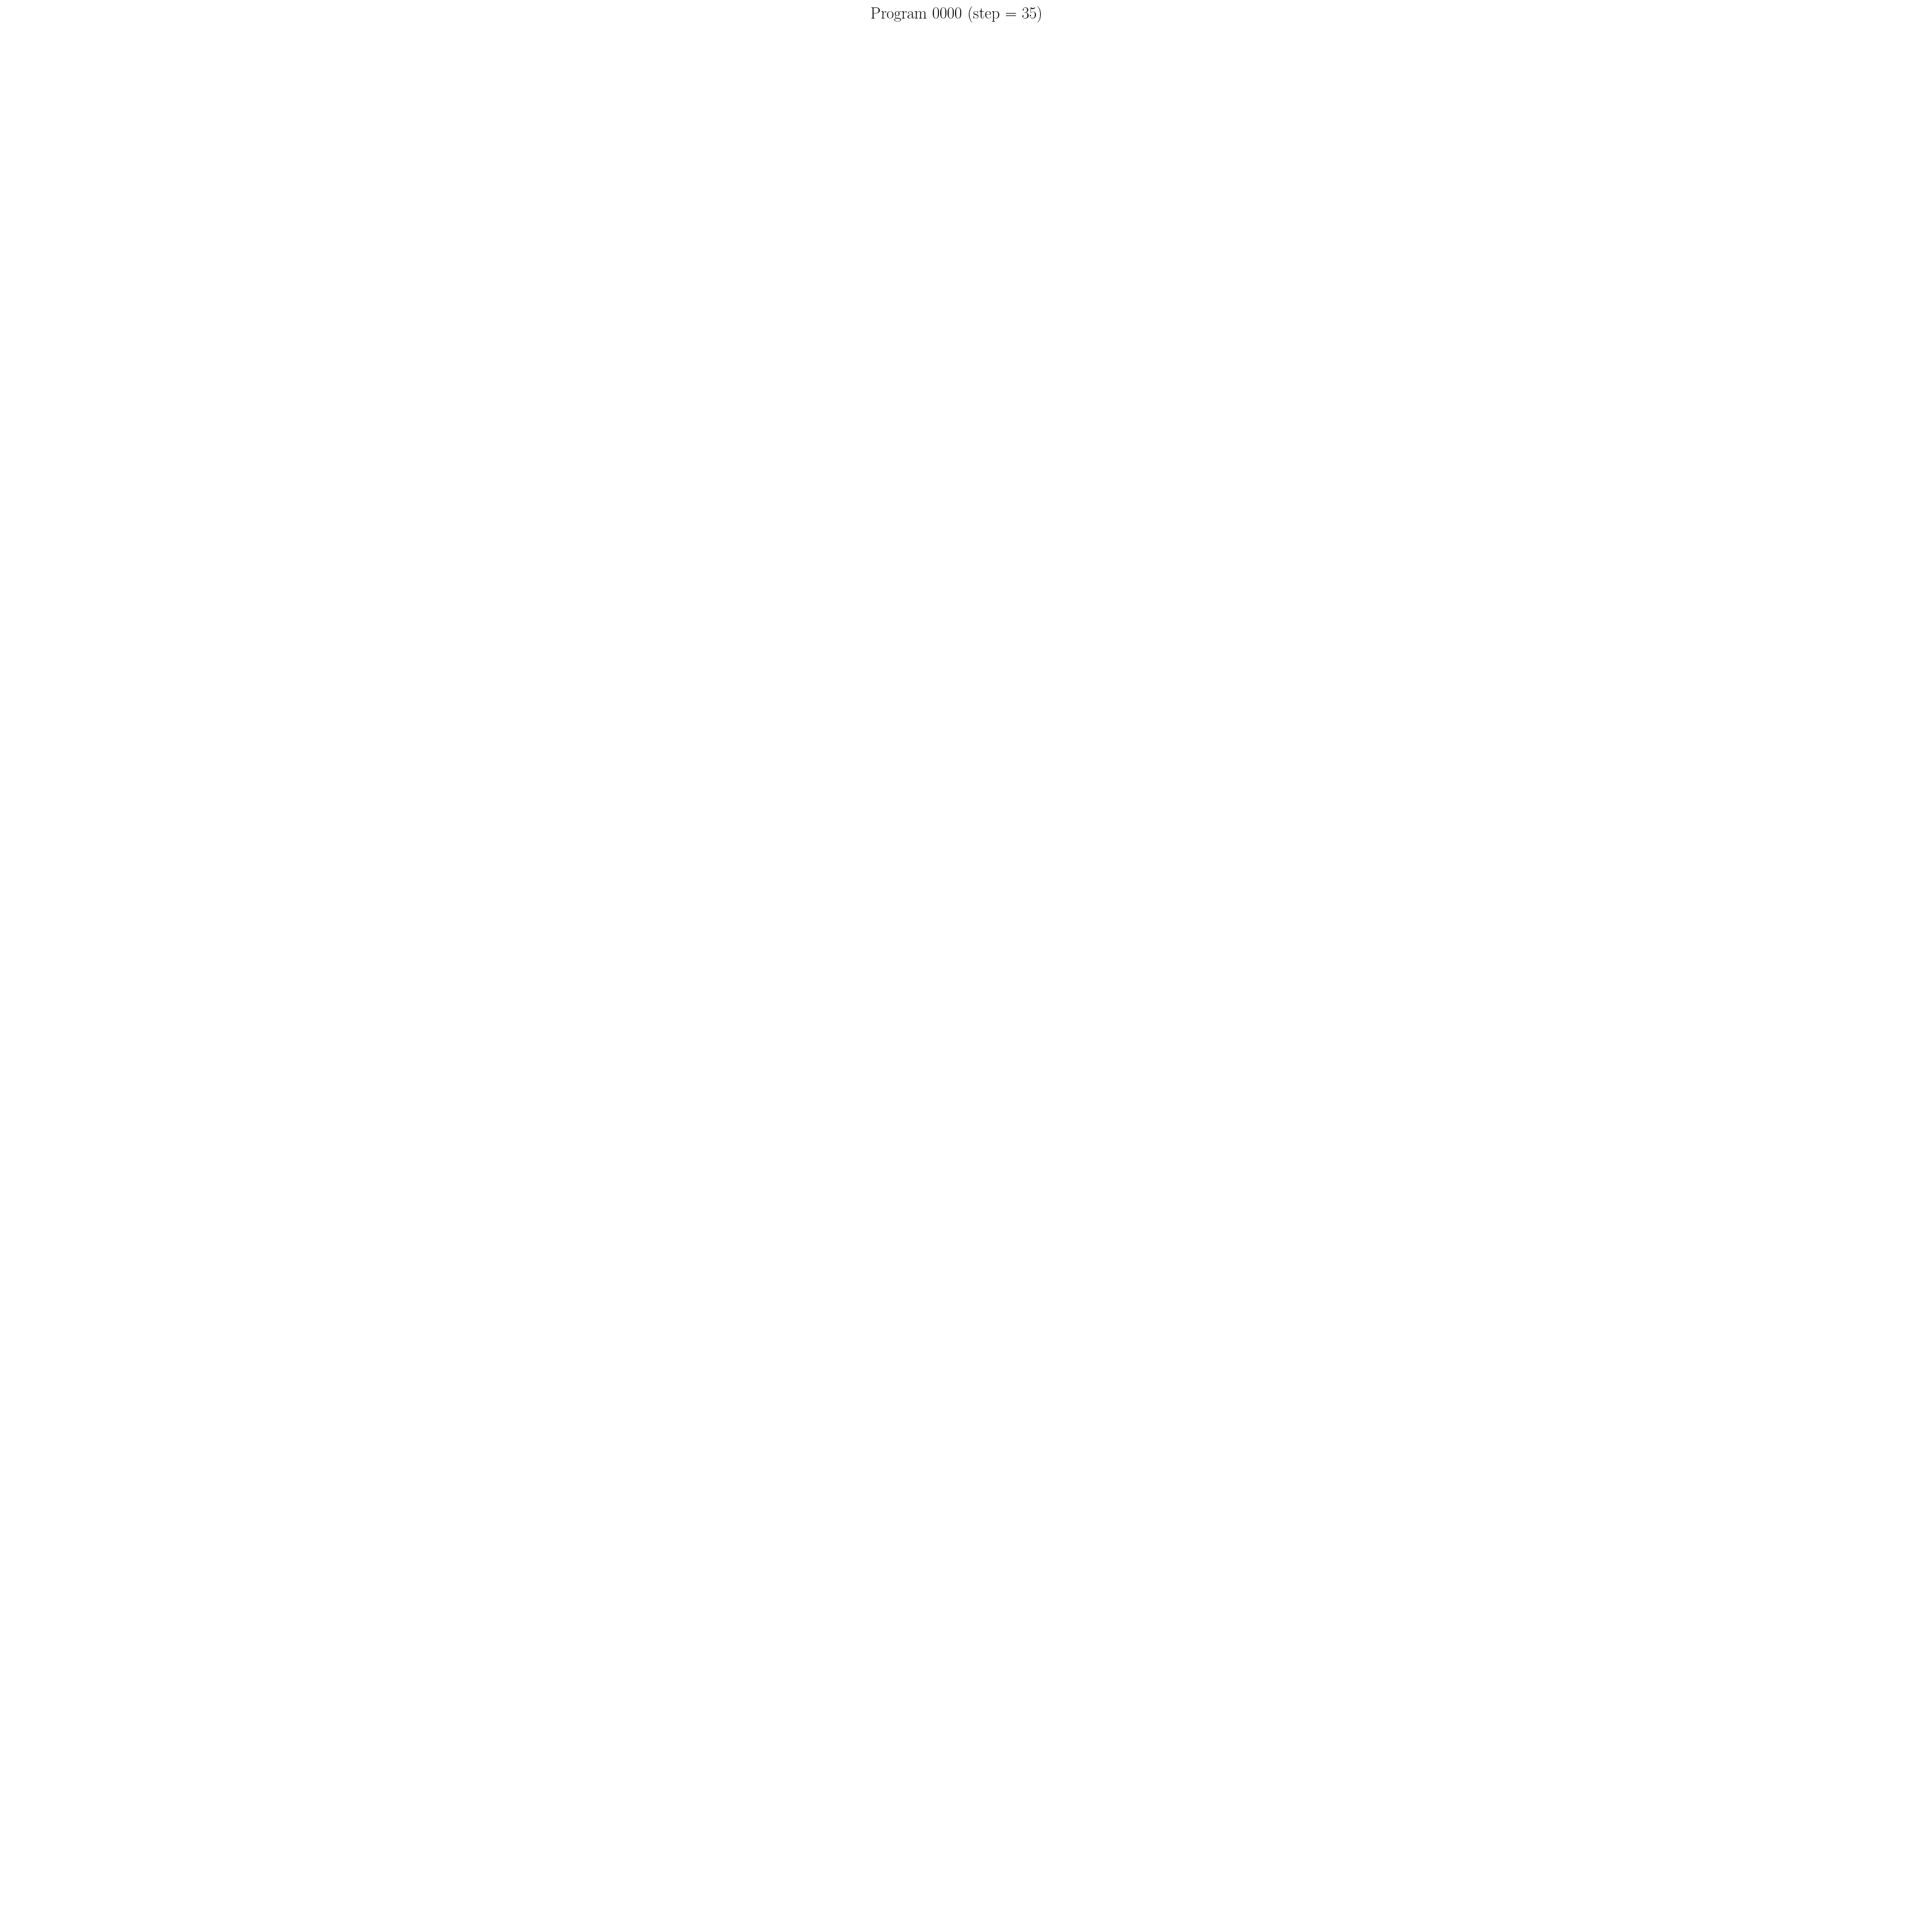

In [47]:
# Showing tree of expression no 0
try:
    expressions_with_da.show_tree(0, via_tex = True, figsize = (40,40), dpi = 300)
except:
    warnings.warn("Tree visualization requires additional dependencies. Please install them via devreq.txt. Tree visualization is optional and not required for the use of physo.")


### One equation, multiple datasets

Expressions can contain dataset-specific free constant for which the values can be optimized independently for each dataset. This is useful when you want to use the same equation across multiple datasets, each with its own set of free constants e.g. when you have access to multiple realizations of a single physical phenomenon.

This is done by using `spe_free_consts_x` arguments (in the same way as `free_consts_x` arguments) when generating the expressions. In addition, the `n_realizations` argument is used to specify the number of datasets (realizations).

In this example, in addition to the free constants `c0`, `c1`, `c2`, we will use two dataset-specific free constants `k0` and `k1` which will each have different values for each of the `n_realizations = 5` datasets.

In [48]:
expressions = rs.sample_random_expressions(
    # Batch size
    batch_size=1000,
    # Max length
    max_length=30,
    # Soft length prior
    length_soft_loc= 12.,
    length_soft_scale= 5.,
    # X
    X_names = ["x1",],
    # y
    y_name = "y",
    # Fixed constants
    fixed_consts       = [1.],
    # Free constants
    free_consts_names = ["c0", "c1", "c2",],
    # Dataset-specific free constants
    spe_free_consts_names = ["k0", "k1"],
    n_realizations = 5,
    # Operations to use
    op_names = ["add", "sub", "mul", "div", "pow", "log", "exp", "cos"],
    # Device to use
    device=device,
    # verbose
    verbose=False
)

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/task/args_handler.py:94: UserWarning: No units given for input variables, assuming dimensionless units.
  warnings.warn("No units given for input variables, assuming dimensionless units.")
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/task/args_handler.py:106: UserWarning: No units given for root variable, assuming dimensionless units.
  warnings.warn("No units given for root variable, assuming dimensionless units.")
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/task/args_handler.py:126: UserWarning: No units given for fixed constants, assuming dimensionless units.
  warnings.warn("No units given for fixed constants, assuming dimensionless units.")
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/task/args_handler.py:153: UserWarning: No units

Randomizing free constants values

In [49]:
expressions.free_consts.class_values = torch.rand_like(expressions.free_consts.class_values, device=device)
expressions.free_consts.spe_values   = torch.rand_like(expressions.free_consts.spe_values,   device=device)

#### Accessing the free constants values of a single expression:

In [50]:
# Inspecting an expression that contains input variables
contains_input_vars = expressions.tokens.is_input_var.sum(axis=1)>0
interesting_idx = np.where(contains_input_vars)[0][17]
expr = expressions[interesting_idx]
print(expr.get_infix_pretty())

           ⎛c₁⋅cos(k₁)⎞
log(x₁)⋅log⎜──────────⎟
           ⎝    k₁    ⎠


In [51]:
expr.free_consts

FreeConstantsTable
 -> Class consts (['c0' 'c1' 'c2']) : (1, np.int64(3))
 -> Spe consts   (['k0' 'k1']) : (1, np.int64(2), 5)

In [52]:
# Regular free constants values
expr.free_consts.class_values # (1, n_free_consts)

tensor([[0.9867, 0.3056, 0.7874]], dtype=torch.float64)

In [53]:
# Dataset-specific free constants values
expr.free_consts.spe_values # (1, n_realizations, n_spe_free_consts)

tensor([[[0.2645, 0.1295, 0.0577, 0.9030, 0.4380],
         [0.9728, 0.9633, 0.8085, 0.3714, 0.8273]]], dtype=torch.float64)

#### Acessing the free constants values of all expressions in the batch:

In [54]:
expressions.free_consts

FreeConstantsTable
 -> Class consts (['c0' 'c1' 'c2']) : (1000, np.int64(3))
 -> Spe consts   (['k0' 'k1']) : (1000, np.int64(2), 5)

In [55]:
# Regular free constants values
expressions.free_consts.class_values   # (batch_size, n_free_consts)

tensor([[0.1859, 0.7438, 0.4885],
        [0.1932, 0.9429, 0.1305],
        [0.9006, 0.4452, 0.8008],
        ...,
        [0.6704, 0.5622, 0.6956],
        [0.1922, 0.8328, 0.4732],
        [0.4110, 0.7917, 0.8044]], dtype=torch.float64)

In [56]:
# Dataset-specific free constants values
expressions.free_consts.spe_values # (batch_size, n_realizations, n_spe_free_consts)

tensor([[[0.1586, 0.2963, 0.7302, 0.6039, 0.9889],
         [0.6697, 0.9385, 0.2421, 0.1898, 0.6313]],

        [[0.4765, 0.6926, 0.9825, 0.3335, 0.4918],
         [0.7667, 0.6564, 0.1514, 0.8627, 0.0423]],

        [[0.2851, 0.4168, 0.1320, 0.8358, 0.9477],
         [0.4859, 0.6743, 0.6047, 0.9427, 0.7787]],

        ...,

        [[0.8441, 0.3861, 0.7322, 0.1878, 0.2931],
         [0.1607, 0.0469, 0.6172, 0.2484, 0.7861]],

        [[0.0229, 0.1411, 0.9087, 0.5510, 0.7278],
         [0.1943, 0.8438, 0.6235, 0.1884, 0.9577]],

        [[0.9743, 0.9798, 0.0449, 0.4856, 0.6264],
         [0.9752, 0.3600, 0.5478, 0.8563, 0.1466]]], dtype=torch.float64)

#### Evaluating and optimizing free parameters of an expression using multiple datasets.

Making fake target data to optimize the expression.

In [57]:
n_samples = 1000
n_dim = 1
X = torch.tensor(np.random.uniform(-1, 1, size=(n_dim, n_samples))).to(device)      # (n_dim, n_samples)

# Making target data for each dataset : harmonic oscillations with different frequencies and phases.
# Realization 0
y_target_0 = 5.*torch.cos(1. * X[0] + 1.1)                                  # (n_samples, )
# Realization 1, ...
y_target_1 = 5.*torch.cos(2. * X[0] + 1.2)                                  # (n_samples, )
y_target_2 = 5.*torch.cos(3. * X[0] + 1.3)                                  # (n_samples, )
y_target_3 = 5.*torch.cos(4. * X[0] + 1.4)                                  # (n_samples, )
y_target_4 = 5.*torch.cos(5. * X[0] + 1.5)                                  # (n_samples, )
# Each realization could have a different number of samples, but here we are using the same number of samples for all realizations for simplicity.

multi_X = [ X, X, X, X, X, ]            # (n_realizations, n_dim, n_inputs)
multi_y_target = [ y_target_0,
                   y_target_1,
                   y_target_2,
                   y_target_3,
                   y_target_4, ]        # (n_realizations, n_samples)

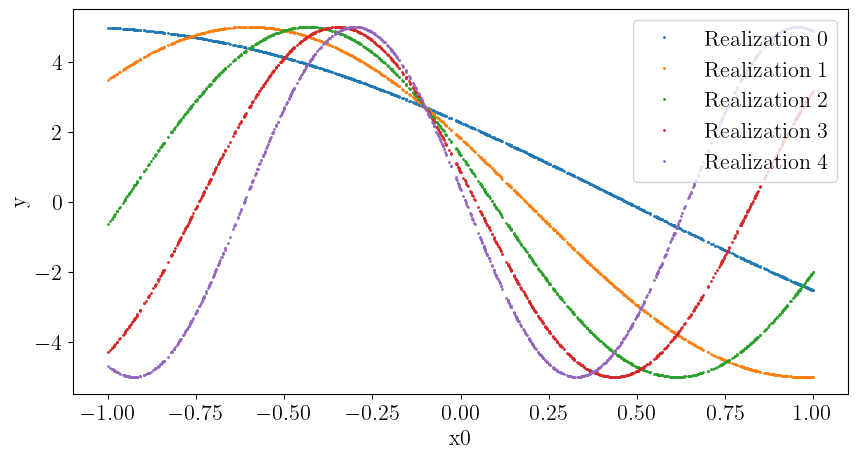

In [58]:
# Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i_real in range (5):
    ax.plot(multi_X[i_real][0].detach().cpu().numpy(), multi_y_target[i_real].detach().cpu().numpy(), '.', markersize=2, label=f'Realization {i_real}')
ax.set_xlabel('x0')
ax.set_ylabel('y')
ax.legend()
plt.show()

Evaluating an expression

In [59]:
# Evaluating the expression on the first realization (ie. using spe free constant values meant for the first dataset)
y_pred = expr(X, i_realization=0) # (n_samples, )

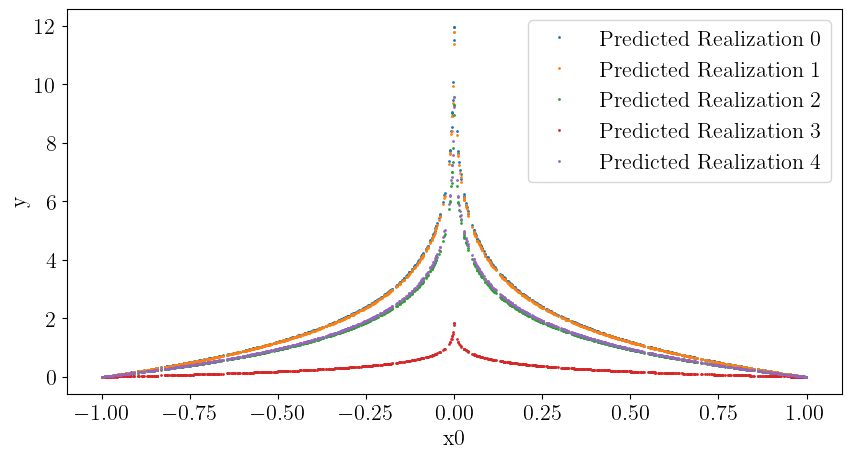

In [60]:
# Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i_real in range (5):
    ax.plot(X[0].detach().cpu().numpy(), expr(multi_X[i_real], i_realization=i_real).detach().cpu().numpy(), '.', markersize=2, label=f'Predicted Realization {i_real}')
ax.set_xlabel('x0')
ax.set_ylabel('y')
ax.legend()
plt.show()

Optimizing an expression to fit the datasets

In [61]:
# Number of samples for each dataset in multi_X/multi_y_target
n_samples_per_dataset = [y.shape[0] for y in multi_y_target]

In [62]:
# Optimizing the expression using all datasets
# Note that X and y must explicitly be flattened and n_samples_per_dataset must be provided to let the function know how to split the data for each dataset.
history = expr.optimize_constants(
    X        = phyd.flatten_multi_data(multi_X),              # (n_dim, sum(n_samples_per_dataset))
    y_target = phyd.flatten_multi_data(multi_y_target),       # (sum(n_samples_per_dataset), )
    n_samples_per_dataset = n_samples_per_dataset,            # (n_realizations, )
)

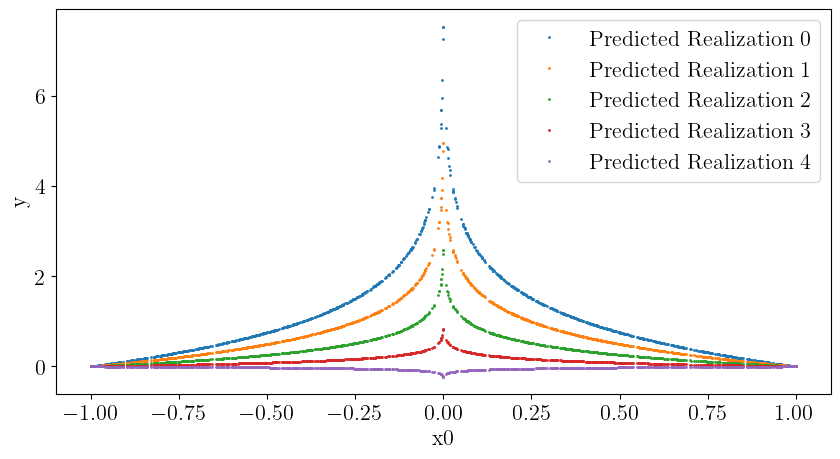

In [63]:
# Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i_real in range (5):
    ax.plot(X[0].detach().cpu().numpy(), expr(multi_X[i_real], i_realization=i_real).detach().cpu().numpy(), '.', markersize=2, label=f'Predicted Realization {i_real}')
ax.set_xlabel('x0')
ax.set_ylabel('y')
ax.legend()
plt.show()